# Replication Report: Predicting the present with Google Trends (P2)
----

In [1]:
#Loading necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline

---

The data:
 * **merged_autos.csv :** Motor Vehicles and Parts Dealers dataset 
	- *Columns :* period, sales, suvs, insurance
 * **merged_iclaims.csv :** Initial Claims for Unemployment Benefits dataset
	- *Columns :* index (the time), claims.sa (seasonally-adjusted), claims.nsa (non-seasonally adjusted), jobs, Welfare_Unemployment

##### Loading the data:

In [2]:
DATA_FOLDER = "Data/"
AUTOS_DEALERS_PATH = DATA_FOLDER + "merged_autos.csv"
CLAIMS_PATH = DATA_FOLDER + "merged_iclaims.csv"

Motor Vehicles and Parts Dealers dataset:

In [3]:
merged_autos = pd.read_csv(AUTOS_DEALERS_PATH)

In [4]:
merged_autos.dtypes

Period        object
sales          int64
suvs         float64
insurance    float64
dtype: object

In [5]:
# Checking if there is any missing values
merged_autos.isnull().sum()

Period       0
sales        0
suvs         0
insurance    0
dtype: int64

In [6]:
#this will be the date parser we'll use to parse the period column of the data
dateparse = lambda x: datetime.strptime(x, '%Y/%m/%d')
merged_autos = pd.read_csv(AUTOS_DEALERS_PATH, parse_dates=['Period'], date_parser=dateparse)
merged_autos.dtypes

Period       datetime64[ns]
sales                 int64
suvs                float64
insurance           float64
dtype: object

----

# Goal:

The goal is to replicate ***figure 2*** of the paper *Predicting the present with google trends*. 

As explained in the paper we will use a simple baseline model at first: an auto regressive model. We will improve this model as a first step using the trend data. 

As a second and final step we will use window forecasting to estimate the data for periods k through t-1. We will take k=17 and compare the MAEs of the models.

## Baseline model:

We first try to replicate the **baseline** model:

We will use a simple AR-1 model:
$$y_{t} = b_{1} y_{t-1} + b_{12} y_{t-12} + e_{t}$$ <div align="right">  where $y_{t}$ is the log of the observation at time t. </div>

In [7]:
#sales time series
log_sales_ts = merged_autos.set_index('Period')
freq = log_sales_ts.index.inferred_freq
log_sales_ts.index = pd.DatetimeIndex(log_sales_ts.index, freq = freq)
log_sales_ts['sales'] = np.log(log_sales_ts['sales'])
log_sales_ts['lag_1'] = log_sales_ts['sales'].shift(1)
log_sales_ts['lag_12'] = log_sales_ts['sales'].shift(12)

From here on we'll use the log of the data `log_sales_ts` since the model we will use will take the log of the values.

In [8]:
# we will fit the AR model using OLS
base_model = smf.ols(formula = "sales ~ lag_1 + lag_12",
                 data=log_sales_ts).fit()

# print the summary of the base model
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     97.00
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           1.20e-21
Time:                        00:31:27   Log-Likelihood:                 89.115
No. Observations:                  79   AIC:                            -172.2
Df Residuals:                      76   BIC:                            -165.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6727      0.764      0.881      0.3

## Improved model: AR-1 model + Google trends

As mentioned in the paper, the experimentaions showed that Google Trends contains two categories that showed an improved in in-sample fit. 

These are:
- Trucks & SUVs ( `suvs` )
- Automotive Insurance ( `insurance`). 

We'll see how this improvement affects our model.

**Adding Google Trands Data:**

This model will be an improved AR-1 model with external data (suvs and insurance):

$$y_{t} = b_{1} y_{t-1} + b_{12} y_{t-12} + \beta_{1} suvs + \beta_{2} insurance + e_{t}$$ <div align="right">  where $y_{t}$ is the log of the observation at time t. </div>

In [9]:
# we will fit the AR model using OLS
trend_model = smf.ols(formula = "sales ~ lag_1 + lag_12 + suvs + insurance",
                 data=log_sales_ts).fit()

print(trend_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     83.08
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           1.35e-26
Time:                        00:31:27   Log-Likelihood:                 106.31
No. Observations:                  79   AIC:                            -202.6
Df Residuals:                      74   BIC:                            -190.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4580      0.784     -0.584      0.5

### Out of sample forecasting, calculating the MAE and plotting:

Now we will use rolling window forecasting, we will take k=17:

In [10]:
# helper functions :

# Mean Absolute Error (calculate_mae)
def calculate_mae(pred, label):
    # label is actual and pred is the prediction
    # since the paper report all MAE in percentage we will multiply it by 100
    return np.mean(np.abs(label - pred))*100

# One-Step-ahead out of sample forecasting (window size = sample_size)
def ols_out_of_sample_forecasts(ols_data, base_formula, trend_formula, label_name, sample_size):
    """
    returns one step ahead out-of-sample predictions on ols_data using base_formula and trend_formula beginning at sample_size.
    
    :param ols_data (DataFrame): the data to use
    :param base_formula (str): patsy style formula to use for OLS model
    :param trend_formula (str): patsy style formula to use for OLS model
    :param label_name (str): the name of the column which to predict
    :param sample_size (int): the minimum sample_size to use. (where to start oos forecasting)
    
    :Returns: the base model and trends model forecasts (DataFrame) and their coressponding MAEs.
    (base_forecasts, trends_forecasts, base_mae, trends_mae)
    :rtype: (DataFrame, DataFrame, float, float)
    
    """
    
    base_forecasts = np.array(ols_data[label_name][:sample_size])
    trends_forecasts = np.array(ols_data[label_name][:sample_size])
    
    base_mae = 0
    trends_mae = 0
    
    for s_s in range(sample_size,len(ols_data)):
        
        sample = ols_data[:s_s]
        
        #base model
        base_model = smf.ols(base_formula, data=sample)
        base_result = base_model.fit()
        
        #Google trends model
        trends_model = smf.ols(trend_formula, data=sample)
        trends_result = trends_model.fit()
        
        #forecasting
        base_for = base_result.predict(ols_data[:s_s+1]).iloc[-1]
        base_forecasts = np.append(base_forecasts, base_for)
        
        trends_for = trends_result.predict(ols_data[:s_s+1]).iloc[-1]
        trends_forecasts = np.append(trends_forecasts, trends_for)
        
    #calculate MAE    
    base_mae = calculate_mae(base_forecasts[sample_size:], ols_data[sample_size:][label_name].values )
    trends_mae = calculate_mae(trends_forecasts[sample_size:], ols_data[sample_size:][label_name].values )
        
    # create dfs
    base_forecasts = pd.DataFrame({label_name: base_forecasts}).set_index(ols_data.index)
    trends_forecasts = pd.DataFrame({label_name: trends_forecasts}).set_index(ols_data.index)
    
    return base_forecasts, trends_forecasts, base_mae, trends_mae


In [11]:
# we choose sample_size = k = 17, which implies the forecasts start on 2005-06-01.
sample_size = 17
base_pred, trends_pred, base_mae, trends_mae = ols_out_of_sample_forecasts(log_sales_ts, 
                                                                           base_formula="sales ~ lag_1 + lag_12",
                                                                           trend_formula="sales ~ lag_1 + lag_12 + suvs + insurance",
                                                                           label_name="sales", 
                                                                           sample_size=sample_size)

# overall
improvement_overall = (1 - (trends_mae/base_mae)) * 100
print("Overall:")
print("The base model has an MAE : {:.2f}".format(base_mae))
print("The google trends model has an MAE : {:.2f}".format(trends_mae))
print("We have an improvement of {:.2f}%".format(improvement_overall))
print("-"*80)

# during recession:
data_re = log_sales_ts['2007-12-01':'2009-06-30']['sales'].values
base_re = base_pred['2007-12-01':'2009-06-30']['sales'].values
trends_re = trends_pred['2007-12-01':'2009-06-30']['sales'].values

base_mae_re = calculate_mae(base_re, data_re)
trends_mae_re = calculate_mae(trends_re, data_re)
improvement_re = (1 - (trends_mae_re/base_mae_re)) * 100
print("During recession:")
print("The base model has an MAE : {:.2f}".format(base_mae_re))
print("The google trends model has an MAE : {:.2f}".format(trends_mae_re))
print("We have an improvement of {:.2f}%".format(improvement_re))

Overall:
The base model has an MAE : 6.34
The google trends model has an MAE : 5.67
We have an improvement of 10.66%
--------------------------------------------------------------------------------
During recession:
The base model has an MAE : 8.87
The google trends model has an MAE : 6.97
We have an improvement of 21.46%


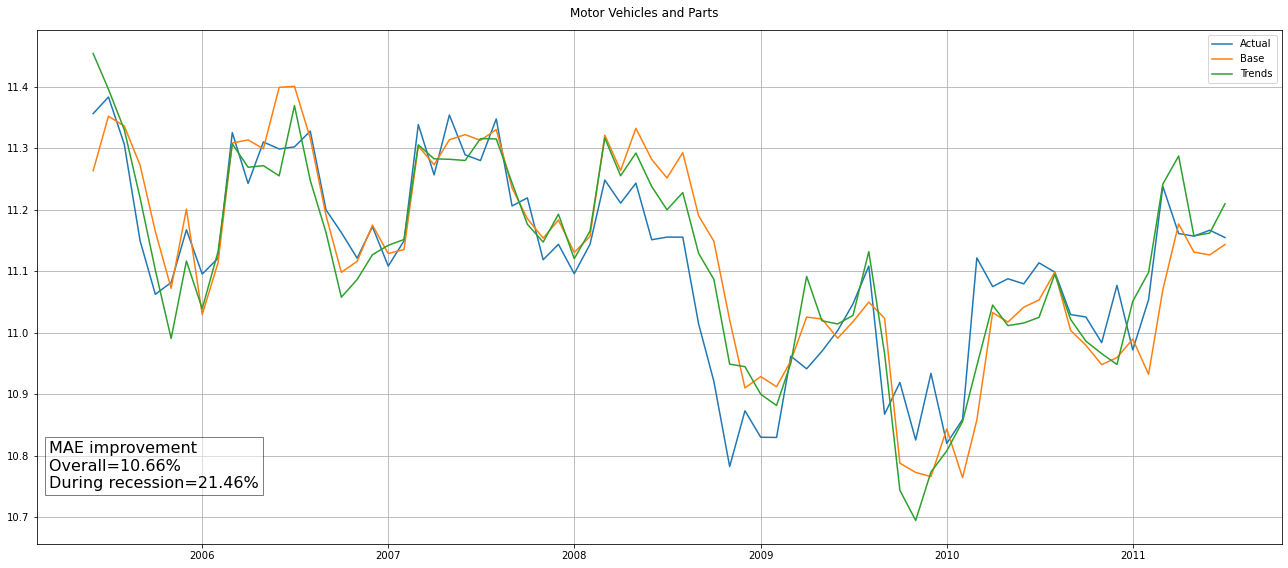

In [12]:
# Plotting the figure:
fig, ax = plt.subplots(figsize=(18,8))
fig.suptitle('Motor Vehicles and Parts')
plt.grid(True)
ax.plot(log_sales_ts[sample_size:]['sales'], label="Actual")
ax.plot(base_pred[sample_size:]['sales'], label="Base")
ax.plot(trends_pred[sample_size:]['sales'], label="Trends")

text = "MAE improvement \nOverall={overall:.2f}% \nDuring recession={recession:.2f}%".format(overall=improvement_overall,recession=improvement_re)
props = dict(facecolor='white', alpha=0.5)
ax.text(0.010, 0.2, text, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

---

# Replication Report: Predicting the present with Google Trends (P4)
----

The data consists of:
 * **merged_iclaims.csv :** Initial Claims for Unemployment Benefits dataset
	- *Columns :* `index` (the time), `claims.sa` (seasonally-adjusted), `claims.nsa` (non-seasonally adjusted), `jobs`, `Welfare_Unemployment`

##### Loading the data and preprocessing it:

In [13]:
data = pd.read_csv(CLAIMS_PATH)

In [14]:
# Checking if there is any missing values
data.isnull().sum()

Index                     0
claims.sa                 0
claims.nsa                0
Jobs                      0
Welfare...Unemployment    0
dtype: int64

In [15]:
data.dtypes

Index                      object
claims.sa                   int64
claims.nsa                  int64
Jobs                      float64
Welfare...Unemployment    float64
dtype: object

In [16]:
data['Index'] = pd.to_datetime(data['Index'])
data.dtypes

Index                     datetime64[ns]
claims.sa                          int64
claims.nsa                         int64
Jobs                             float64
Welfare...Unemployment           float64
dtype: object

We will rename the columns so that we can use them in the patsy style formulas without errors

In [17]:
data = data.rename(columns={"claims.sa": "claims_sa", "claims.nsa": "claims_nsa","Welfare...Unemployment": "Welfare_Unemployment"}).set_index("Index")
data.head(5)

,claims_sa,claims_nsa,Jobs,Welfare_Unemployment
Index,,,,
2004-01-10,354000,677897,6.066862,-7.574152
2004-01-17,362000,490763,-3.558773,-25.237886
2004-01-24,353000,382262,-6.184409,-17.401619
2004-01-31,376000,406298,-7.935044,-18.815352
2004-02-07,380000,433234,-13.310680,-24.104085


----

### Fitting the AR model to the data:

As before we tried to fit an AR-1 model using the ar_model.AutoReg provided by statsmodels but faced a lot of ambiguities and erros that's why we chose to use a simple OLS model, we modeled the lag by shifting the column in question.

We will use a simple AR-1 model:
$$y_{t} = b_{1} y_{t-1} + e_{t}$$ <div align="right">  where $y_{t}$ is the log of the observation at time t. </div>

and then we will try and fit another model by adding the google trends data:

$$y_{t} = b_{1} y_{t-1} + \beta_{1} jobs + \beta_{2} welfare..unemployment + e_{t}$$ <div align="right">  where $y_{t}$ is the log of the observation at time t. </div>

Below are the helper functions we used to replicate **Table 1** of the paper. 

We will use some helper functions defined for the replication of the **Figure 2** of the last milestone (P2) **above**. (`ols_out_of_sample_forecasts`)

In [18]:
#Helper functions:

# Create the metrics we will use for the data to create Table 1 (MAE and 1-Ratio)
def create_metrics_for_period(data,df_base, df_trends, start_date, end_date, label_name):
    """
    Returns the Mean Absolute Error between the data and df_base and df_trends respectively during the start_date-end_date period.
    The DataFrames should be indexed in DatetimeIndex.
    
    :param data (DataFrame): the actual data. (True labels)
    :param df_base (DataFrame): the base model data.
    :param df_trends (DataFrame): the trends model data.
    :param start_date (str): the start date in (YYYY-mm-dd) format
    :param end_date (str): the end date in (YYYY-mm-dd) format
    :param label_name: the label name on which the models worked.
    
    :Returns: (the base model MAE, the trends model MAE, the improvement during the period, the period)
    :rtype: (float, float, float, str (YYYY-mm-dd YYYY-mm-dd) )

    """
    
    # get the corresponding data of the date range
    base_model_re = df_base[start_date:end_date][label_name].values
    trends_model_re = df_trends[start_date:end_date][label_name].values
    re_data = data[start_date:end_date][label_name].values

    # calculate the MAE and the improvement (1-ratio)
    base_mae_re, trends_mae_re = calculate_mae(base_model_re, re_data) / 100, calculate_mae(trends_model_re, re_data) / 100
    improvement = (1 - (trends_mae_re / base_mae_re)) * 100
    
    # return the date_range for which the metrics were calculated
    date_range = [start_date, end_date]

    return base_mae_re, trends_mae_re, improvement, date_range

In [19]:
ols_data = data.copy()
# data preprocessing
ols_data['log_claims_sa'] = np.log(ols_data['claims_sa'])
ols_data['log_claims_sa_1'] = ols_data['log_claims_sa'].shift(1)

sample_size = 5
# Out-of-sample forecasting (OLS)
base_forecasts, trends_forecasts, base_mae, trends_mae = ols_out_of_sample_forecasts(ols_data, base_formula="log_claims_sa ~ log_claims_sa_1",
                                                                           trend_formula="log_claims_sa ~ log_claims_sa_1 + Jobs + Welfare_Unemployment",
                                                                           label_name="log_claims_sa", sample_size=sample_size)

In [20]:
r1_base_mae, r1_trends_mae, imp1, range1 = create_metrics_for_period(ols_data, base_forecasts, trends_forecasts,
                                                             start_date='2009-03-01',end_date='2009-05-01', label_name="log_claims_sa")


r2_base_mae, r2_trends_mae, imp2, range2 = create_metrics_for_period(ols_data, base_forecasts, trends_forecasts,
                                                             start_date='2009-12-01',end_date='2010-02-01', label_name="log_claims_sa")


r3_base_mae, r3_trends_mae, imp3, range3 = create_metrics_for_period(ols_data, base_forecasts, trends_forecasts,
                                                             start_date='2010-07-15',end_date='2010-09-30', label_name="log_claims_sa")


r4_base_mae, r4_trends_mae, imp4, range4 = create_metrics_for_period(ols_data, base_forecasts, trends_forecasts,
                                                             start_date='2011-01-01',end_date='2011-05-01', label_name="log_claims_sa")

In [21]:
ranges = np.array([range1, range2, range3, range4])
mae_base = [r1_base_mae, r2_base_mae, r3_base_mae, r4_base_mae]
mae_trends = [r1_trends_mae, r2_trends_mae, r3_trends_mae, r4_trends_mae]
improvements = [imp1, imp2, imp3, imp4]


df = pd.DataFrame({"Start":ranges[:,0], "End":ranges[:,1], "MAE base": mae_base, 
                   "MAE trends": mae_trends, "1-ratio": improvements}).set_index(["Start","End"])

styler = df.style.format({"MAE base": "{:.4f}", 
                  "MAE trends": "{:.5f}", "1-ratio": "{:.2f}%"})
styler

,,MAE base,MAE trends,1-ratio
Start,End,,,
2009-03-01,2009-05-01,0.0307,0.02399,21.86%
2009-12-01,2010-02-01,0.0357,0.03127,12.36%
2010-07-15,2010-09-30,0.0253,0.02446,3.22%
2011-01-01,2011-05-01,0.0514,0.05101,0.66%


- The values of the last two rows are swapped in the paper. This maybe due to some error on the authors side or some typo.
- We can see that there is a not a big difference between these results and the paper's, the only one noticeable is the rounding effect of floats. 

**Conclusions:**
- These results combined with the previous figure show that the Google trends data can really be a good addition to certain models (AR-1 in our case) and improve its fit (Figure 2) and if not, it can be a good indicator of the turning points in timeseries as showed in the table 1.

------